# Proposal

## Dataset Link: 
[ftp link](https://www.nhtsa.gov/node/97996/206)

Documentation is found at: <br>
[Overview](https://www.nhtsa.gov/crash-data-systems/crash-investigation-sampling-system)
<br>
[Analytical User Manual](https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812803)
<br>
[Coding Manual](https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812735)

## Description:
The Crash Investigation Sampling System (CISS) is a highly detailed dataset collected by specially trained teams within the National Highway Traffic Safety Administration (NHTSA) for use in improving vehicle safety. NHTSA has stated that the purpose of this database is to support scientists and engineers in analyzing motor vehicle crashes and injuries.

The data are collected using crash reconstruction (on-scene measurements, vehicle measurements, etc.), interviews of the individuals involved in the collision, and medical records. Inclusion criteria are that at least one of the vehicles involved in the collision are towed from the scene. Data are sampled from among 32 strategic areas across the USA, designed to represent the USA as a whole (weighting factors are provided for scaling and generalization of results, where applicable).

![CISS Map](CISS_MAP.png)

The database has numerous tables at the crash level, vehicle level, person level, and injury level. There are specific keys that are used to link the tables to each other. A simple data model for the CISS database is shown below.

<img src="CISS_Data_Mdl.jpg" width="600">


## Target Variable:
MIAS (Maximum Abbreviated Injury Scale for a person).

## Questions:
- How does distracted driving impact collision severity?
- Which model performs best for predicting injury severity - ordinal logit (using statsmodels) or random forest?
- Can random forest be interpreted at an aggregate level for each predictor (e.g., using partial dependence plots or other methods)? If so, how do the results compare with the ordinal logit interpretation?

Note: I have worked with this dataset quite a bit, including applying ordinal logistic regression to predicting injury severity, so the key learning opportunity is in using the random forest. The comparisons are something I am highly interested in.

# Import Data and Initial Views

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read in the data.
crash = pd.read_csv('Data/CRASH.CSV',encoding='cp1252')
veh = pd.read_csv('Data/GV.CSV',encoding='cp1252')
#cdc = pd.read_csv('Data/CDC.CSV',encoding='cp1252') #  Collision Deformation Classification
person = pd.read_csv('Data/OCC.CSV',encoding='cp1252')
distract = pd.read_csv('Data/DISTRACT.CSV',encoding='cp1252')

In [3]:
crash.head()

,CASEID,CRASHYEAR,PSU,CASENO,CASENUMBER,CATEGORY,CRASHMONTH,DAYOFWEEK,CRASHTIME,CONFIG,...,CINJURED,CINJSEV,CTREAT,ALCINV,DRGINV,MANCOLL,SUMMARY,CASEWGT,PSUSTRAT,VERSION
0,6150,2017.0,10,1,1-10-2017-001-09,9.0,1.0,3.0,19:23,5.0,...,1.0,0.0,3.0,9.0,1.0,0.0,V1 was traveling south in lane three on a divi...,1076.863485,4.0,2.0
1,6228,2017.0,10,3,1-10-2017-003-09,9.0,1.0,5.0,17:57,2.0,...,1.0,0.0,5.0,2.0,2.0,5.0,V1 was traveling northbound in lane five of a ...,1098.361402,4.0,2.0
2,6295,2017.0,10,4,1-10-2017-004-04,4.0,1.0,1.0,15:26,2.0,...,0.0,0.0,9.0,2.0,2.0,0.0,Unit 1 was westbound when the left side was st...,493.639531,4.0,2.0
3,6344,2017.0,10,5,1-10-2017-005-02,2.0,2.0,7.0,01:06,5.0,...,1.0,0.0,8.0,1.0,2.0,0.0,V1 was traveling east bound on the roadway neg...,53.682104,4.0,2.0
4,6388,2017.0,10,6,1-10-2017-006-03,3.0,2.0,6.0,08:11,5.0,...,0.0,0.0,8.0,9.0,2.0,0.0,"V1 was traveling south on a three-lane, divide...",75.975202,4.0,2.0


In [4]:
veh.head()

,CASEID,PSU,CASENO,CASENUMBER,CATEGORY,VEHNO,VIN,VINLENGTH,MAKE,MODEL,...,DVCONF,VAIS,VISS,VINJURED,VTREAT,INITOBJCLASS,HEADANGLECAT,CASEWGT,PSUSTRAT,VERSION
0,6150,10,1,1-10-2017-001-09,9,1,3G5DA03E44S5,17,18,401,...,1.0,2,5.0,0,3.0,0.0,998.0,1076.863485,4,2
1,6228,10,3,1-10-2017-003-09,9,1,1HGCM56396A0,17,37,32,...,0.0,1,1.0,0,5.0,0.0,998.0,1098.361402,4,2
2,6228,10,3,1-10-2017-003-09,9,2,1XP5DB9X9TN4,17,87,881,...,NaN,95,95.0,95,95.0,NaN,NaN,1098.361402,4,2
3,6295,10,4,1-10-2017-004-04,4,1,1FADP3F26DL2,17,12,37,...,0.0,0,0.0,0,0.0,0.0,998.0,493.639531,4,2
4,6295,10,4,1-10-2017-004-04,4,2,1GTEC19M9TE5,17,23,481,...,0.0,0,0.0,0,99.0,0.0,997.0,493.639531,4,2


In [5]:
person.head()

,CASEID,PSU,CASENO,CASENUMBER,CATEGORY,VEHNO,OCCNO,SEATLOC,AGE,HEIGHT,...,EMSGCSTIME,EMSGCSLOC,EMSGCS,EMSGCSEYE,EMSGCSVERB,EMSGCSMOTOR,EMSGCSMOD,CASEWGT,PSUSTRAT,VERSION
0,6150,10,1,1-10-2017-001-09,9,1,1,11,25,170,...,9999,NaN,NaN,NaN,NaN,NaN,NaN,1076.863485,4,2
1,6150,10,1,1-10-2017-001-09,9,1,2,13,28,999,...,9999,NaN,NaN,NaN,NaN,NaN,NaN,1076.863485,4,2
2,6150,10,1,1-10-2017-001-09,9,1,3,21,2,999,...,9999,NaN,NaN,NaN,NaN,NaN,NaN,1076.863485,4,2
3,6150,10,1,1-10-2017-001-09,9,1,4,31,2,999,...,9999,NaN,NaN,NaN,NaN,NaN,NaN,1076.863485,4,2
4,6150,10,1,1-10-2017-001-09,9,1,5,32,27,999,...,9999,NaN,NaN,NaN,NaN,NaN,NaN,1076.863485,4,2


In [6]:
distract.head()

,CASEID,PSU,CASENO,CASENUMBER,CATEGORY,VEHNO,DISTRACTN,CASEWGT,PSUSTRAT,VERSION
0,7202,10,28,1-10-2017-028-03,3,1,1,224.661315,4,2
1,7295,10,30,1-10-2017-030-06,6,1,2,310.417771,4,2
2,7931,10,40,1-10-2017-040-06,6,1,10,1655.852752,4,2
3,8851,10,66,1-10-2017-066-03,3,1,7,49.947185,4,2
4,6424,11,4,1-11-2017-004-03,3,1,10,2276.038983,8,2


In [7]:
crash.shape

(2038, 24)

In [8]:
veh.shape

(3748, 97)

In [9]:
person.shape

(4235, 87)

In [10]:
distract.shape

(406, 10)

## Keeping potential variables of interest

In [11]:
crash.columns

Index(['CASEID', 'CRASHYEAR', 'PSU', 'CASENO', 'CASENUMBER', 'CATEGORY',
       'CRASHMONTH', 'DAYOFWEEK', 'CRASHTIME', 'CONFIG', 'EVENTS', 'VEHICLES',
       'CAIS', 'CISS', 'CINJURED', 'CINJSEV', 'CTREAT', 'ALCINV', 'DRGINV',
       'MANCOLL', 'SUMMARY', 'CASEWGT', 'PSUSTRAT', 'VERSION'],
      dtype='object')

In [12]:
ccols = ['CASEID', 'CASENO', 'CRASHMONTH', 'DAYOFWEEK', 'CRASHTIME', 'MANCOLL', 'CASEWGT']
crash_df = crash[ccols]
crash_df.head()

,CASEID,CASENO,CRASHMONTH,DAYOFWEEK,CRASHTIME,MANCOLL,CASEWGT
0,6150,1,1.0,3.0,19:23,0.0,1076.863485
1,6228,3,1.0,5.0,17:57,5.0,1098.361402
2,6295,4,1.0,1.0,15:26,0.0,493.639531
3,6344,5,2.0,7.0,01:06,0.0,53.682104
4,6388,6,2.0,6.0,08:11,0.0,75.975202


In [13]:
veh.columns

Index(['CASEID', 'PSU', 'CASENO', 'CASENUMBER', 'CATEGORY', 'VEHNO', 'VIN',
       'VINLENGTH', 'MAKE', 'MODEL', 'MODELYR', 'BODYTYPE', 'BODYCAT',
       'VEHCLASS', 'SPECUSE', 'TRANSTAT', 'DAMPLANE', 'DAMSEV', 'CURBWT',
       'CURBSRC', 'CARGOWT', 'CARGOSRC', 'INSPTYPE', 'TOWSTAT', 'SPEEDLIMIT',
       'DRPRESENT', 'PARALCOHOL', 'ALCTEST', 'ALCTESTRESULT', 'ALCTESTSRC',
       'PARDRUG', 'DRUGTEST', 'ZIP', 'RACE', 'ETHNICITY', 'RELTOJUNCT',
       'TRAFFLOW', 'RDLANES', 'INITLANE', 'SURFTYPE', 'SURFCOND', 'ALIGNMENT',
       'PROFILE', 'LINERIGHT', 'LINELEFT', 'RUMBINIT', 'RUMBROAD', 'LIGHTCOND',
       'WEATHER', 'TRAFDEV', 'TRAFFUNCT', 'DISTRACT', 'PREFHE', 'PREMOVE',
       'CRITCAT', 'CRITEVENT', 'MANEUVER', 'PRESTAB', 'PRELOC', 'CRASHCAT',
       'CRASHCONF', 'CRASHTYPE', 'ROLLTYPE', 'ROLLTURN', 'ROLLINTRPT',
       'ROLLPREMAN', 'ROLLINITYP', 'ROLLINLOC', 'ROLLOBJ', 'ROLLTRIP',
       'ROLLDIR', 'ROLLDIST', 'DVANGTHIS', 'DVANGOTH', 'TOWHITCH', 'TRAJDOC',
       'TREEPOLE', 'DVE

When the crash reconstruction is confident in the delta-V (i.e., change in speed during the collision), DVTOTAL is recorded. Otherwise, delta-V is coded in the most likely range of values in the feild DVEST

In [14]:
vcols = ['CASEID', 'VEHNO', 'MODELYR',  'DAMPLANE', 'SPEEDLIMIT','PARALCOHOL','RELTOJUNCT','TRAFFLOW',  'LIGHTCOND','WEATHER', 'DISTRACT', 'DVTOTAL','DVEST']
veh_df = veh[vcols]
veh_df.DVTOTAL = veh_df.DVTOTAL.replace(999,np.NaN) # Note: 999 in DVTOTAL indicates missing values
veh_df.DVEST = veh_df.DVEST.replace(999,np.NaN) # Note: 999 in DVEST indicates missing values
veh_df.head() 

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,CASEID,VEHNO,MODELYR,DAMPLANE,SPEEDLIMIT,PARALCOHOL,RELTOJUNCT,TRAFFLOW,LIGHTCOND,WEATHER,DISTRACT,DVTOTAL,DVEST
0,6150,1,2004,F,89.0,9.0,1.0,2.0,3.0,2.0,1.0,35.0,0.0
1,6228,1,2006,L,105.0,0.0,0.0,2.0,3.0,8.0,1.0,NaN,7.0
2,6228,2,1996,L,105.0,0.0,0.0,2.0,3.0,8.0,9.0,NaN,NaN
3,6295,1,2013,L,72.0,0.0,2.0,2.0,1.0,4.0,1.0,NaN,6.0
4,6295,2,1996,N,72.0,0.0,2.0,4.0,1.0,4.0,9.0,NaN,9.0


In [15]:
# Create a new delta-V variable combining DVTOTAL and DVEST - Change in speed is likely a good predictor of injury severity
DV = []

for i in range(len(veh_df)):
    if (veh_df.DVTOTAL[i]<10) & (veh_df.DVTOTAL[i]>0):
        DV.append(1)
    elif (veh_df.DVTOTAL[i]>=10) & (veh_df.DVTOTAL[i]<25):
        DV.append(2)
    elif (veh_df.DVTOTAL[i]>=25) & (veh_df.DVTOTAL[i]<40):
        DV.append(3)
    elif (veh_df.DVTOTAL[i]>=40) & (veh_df.DVTOTAL[i]<55):
        DV.append(3)
    elif veh_df.DVTOTAL[i]>=55:
        DV.append(3)
    else:
        DV.append(veh_df.DVEST[i])

veh_df['DV'] = DV

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
veh_df['DV'].value_counts()

2.0    1482
3.0     613
9.0     563
1.0     284
7.0     195
6.0     164
0.0      91
8.0      60
4.0      20
5.0      14
Name: DV, dtype: int64

In [17]:
veh_df.isnull().sum()

CASEID           0
VEHNO            0
MODELYR          0
DAMPLANE         0
SPEEDLIMIT     120
PARALCOHOL     120
RELTOJUNCT     120
TRAFFLOW       120
LIGHTCOND      120
WEATHER        120
DISTRACT       120
DVTOTAL       1664
DVEST          262
DV             262
dtype: int64

In [18]:
person.columns

Index(['CASEID', 'PSU', 'CASENO', 'CASENUMBER', 'CATEGORY', 'VEHNO', 'OCCNO',
       'SEATLOC', 'AGE', 'HEIGHT', 'WEIGHT', 'SEX', 'FETALMORT', 'ROLE',
       'RACE', 'ETHNICITY', 'EYEWEAR', 'PARBELTUSE', 'PARAIRBAG', 'PARINJSEV',
       'ENTRAP', 'MOBILITY', 'POSTURE', 'BELTAVAIL', 'BELTUSE', 'BELTLAPPOS',
       'BELTSHLPOS', 'BELTMALF', 'BELTANCHOR', 'BELTUSESRC', 'BELTPOSDEVPRES',
       'BELTPOSDEVUSE', 'BELTGUIDE', 'CHILDSEATUSE', 'MORTALITY', 'TREATMENT',
       'MEDFACILITY', 'HOSPSTAY', 'WORKDAYS', 'INJSTATUS', 'DEATH', 'INJNUM',
       'EMSDATA', 'IMPAIREDCOAG', 'PREGNANT', 'IMPLANTFUS', 'CARDIOCOND',
       'OSTEOCOND', 'SPINEDEGEN', 'OBESITY', 'COMORBOTH', 'CAUSE1', 'CAUSE2',
       'CAUSE3', 'MAIS', 'ISS', 'BMI', 'HOSPVITALTIME', 'HOSPPULSE',
       'HOSPSYSTOLIC', 'HOSPDIASTOLIC', 'HOSPRESPRATE', 'HOSPVITALSRC',
       'GCSOBTAINED', 'HOSPGCSTIME', 'HOSPGCSLOC', 'HOSPGCS', 'HOSPGCSEYE',
       'HOSPGCSVERB', 'HOSPGCSMOTOR', 'HOSPGCSMOD', 'EMSVITALTIME', 'EMSPULSE',
       

In [19]:
pcols = ['CASEID', 'VEHNO', 'OCCNO', 'MAIS', 'SEATLOC', 'AGE', 'HEIGHT', 'WEIGHT', 'SEX', 'PARBELTUSE', 'PARAIRBAG', 'PARINJSEV',
       'BELTUSE','CHILDSEATUSE', 'TREATMENT','MEDFACILITY', 'HOSPSTAY', 'EMSDATA',  'BMI']
person_df = person[pcols]
person_df.head()

,CASEID,VEHNO,OCCNO,MAIS,SEATLOC,AGE,HEIGHT,WEIGHT,SEX,PARBELTUSE,PARAIRBAG,PARINJSEV,BELTUSE,CHILDSEATUSE,TREATMENT,MEDFACILITY,HOSPSTAY,EMSDATA,BMI
0,6150,1,1,2,11,25,170,73,2,3,2,2,0,0,3,2,3,0,25
1,6150,1,2,0,13,28,999,999,1,3,2,0,0,0,0,0,0,0,100
2,6150,1,3,0,21,2,999,999,2,5,2,0,99,1,0,0,0,0,100
3,6150,1,4,0,31,2,999,999,1,5,2,0,99,1,0,0,0,0,100
4,6150,1,5,0,32,27,999,999,2,2,0,0,99,0,0,0,0,0,100


In [20]:
distract.columns

Index(['CASEID', 'PSU', 'CASENO', 'CASENUMBER', 'CATEGORY', 'VEHNO',
       'DISTRACTN', 'CASEWGT', 'PSUSTRAT', 'VERSION'],
      dtype='object')

In [21]:
dcols = ['CASEID',  'VEHNO','DISTRACTN']
distract_df = distract[dcols]
distract_df.head()

,CASEID,VEHNO,DISTRACTN
0,7202,1,1
1,7295,1,2
2,7931,1,10
3,8851,1,7
4,6424,1,10


In [22]:
person['AGE'].value_counts()

23     128
17     121
19     118
25     114
26     109
21     108
18     108
22     107
20     107
24     101
27      93
28      93
16      86
29      85
30      85
33      83
32      80
31      76
36      70
54      60
37      60
47      59
34      57
44      56
999     56
55      56
50      54
38      54
15      52
43      52
      ... 
11      24
68      23
12      22
73      22
78      22
75      20
76      19
0       19
5       19
9       19
71      18
77      17
82      15
74      14
80      12
79      12
85      11
86      10
84       9
81       8
83       7
88       5
93       3
90       2
94       2
87       1
91       1
89       1
92       1
97       1
Name: AGE, Length: 97, dtype: int64

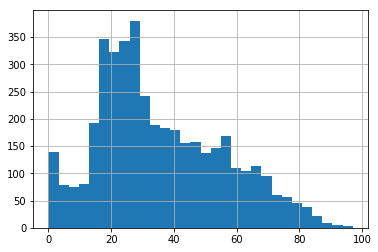

In [23]:
person[person['AGE']<150]['AGE'].hist(bins=30) # note - 999 indicates age is unknown/not reported. There are 56 of these values (i.e., 56 missing values for age)

In [24]:
person.isnull().sum()

CASEID              0
PSU                 0
CASENO              0
CASENUMBER          0
CATEGORY            0
VEHNO               0
OCCNO               0
SEATLOC             0
AGE                 0
HEIGHT              0
WEIGHT              0
SEX                 0
FETALMORT           0
ROLE                0
RACE                0
ETHNICITY           0
EYEWEAR             0
PARBELTUSE          0
PARAIRBAG           0
PARINJSEV           0
ENTRAP              0
MOBILITY            0
POSTURE             0
BELTAVAIL           0
BELTUSE             0
BELTLAPPOS          0
BELTSHLPOS          0
BELTMALF            0
BELTANCHOR          0
BELTUSESRC          0
                 ... 
HOSPVITALTIME    3087
HOSPPULSE        3089
HOSPSYSTOLIC     3089
HOSPDIASTOLIC    3089
HOSPRESPRATE     3089
HOSPVITALSRC     3089
GCSOBTAINED         0
HOSPGCSTIME         0
HOSPGCSLOC       3089
HOSPGCS          3089
HOSPGCSEYE       3089
HOSPGCSVERB      3089
HOSPGCSMOTOR     3089
HOSPGCSMOD       3089
EMSVITALTI

## Some useful dictionaries

In [25]:
seating_dict = {11:'Front Left', 12:'Front Middle', 13:'Front Right', 21:'Second Left', 22:'Second Middle', 23:'Second Right', 31:'Third Left', 
                32:'Third Middle', 33:'Third Right', 99:'Unknown'} # person_df['SEATLOC']

gender_dict = {1:'Male', 2:'Female', 3:'Female-Pregnant 1st Trimester', 4:'Female-Pregnant 2nd Trimester', 
               5:'Female-Pregnant 3rd Trimester', 6:'Female-Trimester Unknown', 9:'Unknown'} # person_df['SEX']

distract_dict = {1:'Sleepy', 2:'Inattentive', 3:'Texting/Typing/Dialing', 4:'Talking-Hands Free', 5:'Talking-Hand Held', 6:'Other Device', 7:'Device Integral to Vehicle', 
                 8:'Passenger', 9:'Other Inside', 10:'Outside Vehicle', 11:'Unknown Distraction', 99:'Not Reported'} # SPecific Distraction Type: distract_df['DISTRACTN']

mancoll_dict = {0:'SingleVehicle',  1:'Rearend',  2:'Headon',  4:'Angle',  5:'Sideswipe - Same Direction',  6:'Sideswipe - Opposite Direction',  9:'Unknown'} # Collision Type: crash_df['MANCOLL']

damage_plane_dict = {'0':'Not Motor Vehicle', '9':'Unkown', 'B':'Back/Truck Back', 'D':'Back/Rear of Tractor', 'F':'Front', 'L':'Left', 
                     'N':'Noncollision', 'R':'Right', 'T':'Top', 'U':'Undercarriage', 'V':'Front of Cargo Area'} # Damage plane on vehicle: veh_df['DAMPLANE']

para_alc_dict = {0:'None Present',  1:'Alcohol Present',  7:'No Driver',  8:'Not Reported',  9:'Unknown'} # Alcohol Present: veh_df['PARALCOHOL']

rel_junction_dict = {0:'No Junction', 1:'Interchange', 2:'Intersection', 3:'Driveway/Alley', 4:'Other Junction', 5:"Unknown Type", 9:'Unknown'} # relation to junction: veh_df['RELTOJUNCT']

traffic_flow_dict = {1:'Divided-Median',  2:'Divided-Median Positive Barrier',  3:'One-Way',  4:'Not Divided',  5:'Two-Way Left Turn Lane', 9:'Unknown'} # traffic flow: veh_df['TRAFFLOW']

lighting_dict = {1:'Daylight',  2:'Dark',  3:'Dark but Lighted',  4:'Dawn',  5:'Dusk',  9:'Unknown'} # Light Conditions: veh_df['LIGHTCOND']

weather_dict = {1:'Clear',  2:'Rain',  3:'Sleet or Hail',  4:'Snow',  5:'Fog, Smoke, Smog',  6:'Severe Crosswinds',  7:'Blowing Sand, Dirt, Soil', 
                8:'Cloudy',  9:'Blowing Snow', 10:'Freezing Rain/Drizzle', 98:'Other', 99:'Unknown'} # Weather Conditions: veh_df['WEATHER']

basic_distract_dict = {0:'No Driver',  1:'Attentive/Not Distracted',  2:'Looked but did not see',  3:'Inattentive/Distracted',  9:'Unknown'} #Basic distractions: veh_df['DISTRACT']

airbag_dict = {0:'None Available', 1:'Deployed', 2:'Not Deployed', 3:'Unknown if Deployed', 7:'Not Reported', 9:'Unknown'} # person_df['PARAIRBAG']

seatbelt_dict = {0:'Not Used', 1:'Shoulder Belt', 2:'Lap Belt', 3:'Shoulder + Lap Belt', 4:'Belt Used, Unknown Type', 5:'Child Seat', 
                 7:'Other Belt Type', 8:'Unknown', 9:'Not Reported'} # person_df['PARBELTUSE']

DV_dict = {0:'Under 10 kph',  1:'Under 10 kph',  2:'10-25 kph',  3:'25-40 kph',  4:'40-55 kph',  5:'Over 55 kph',  6:'Minor Damage',  7:'Moderate Damage',  
           8:'Severe Damage',  9:'Unknown', 99:'Unknown'} # Delta-V Categories: veh_df['DV']

In [26]:
person_df['SEATLOC'].map(seating_dict).value_counts()

Front Left       2896
Front Right       716
Second Right      285
Second Left       216
Second Middle      72
Third Right        14
Third Left         14
Unknown            13
Third Middle        5
Front Middle        4
Name: SEATLOC, dtype: int64

In [27]:
person_df['SEX'].map(gender_dict).value_counts()

Male                             2100
Female                           2055
Unknown                            39
Female-Pregnant 1st Trimester      16
Female-Pregnant 2nd Trimester      13
Female-Pregnant 3rd Trimester      10
Female-Trimester Unknown            2
Name: SEX, dtype: int64

In [28]:
distract_df['DISTRACTN'].map(distract_dict).value_counts()

Sleepy                        103
Outside Vehicle                77
Other Inside                   67
Not Reported                   46
Inattentive                    27
Texting/Typing/Dialing         27
Passenger                      22
Device Integral to Vehicle     18
Talking-Hand Held               9
Other Device                    9
Talking-Hands Free              1
Name: DISTRACTN, dtype: int64

Note: Due to the few observations several types of distractions, it is unlikely that many distraction types will be useful in modeling

In [29]:
crash_df['MANCOLL'].map(mancoll_dict).value_counts()

Angle                             726
SingleVehicle                     697
Rearend                           403
Sideswipe - Same Direction         69
Headon                             54
Sideswipe - Opposite Direction     46
Unknown                            40
Name: MANCOLL, dtype: int64

In [30]:
veh_df['DAMPLANE'].map(damage_plane_dict).value_counts()

Front                   1996
Left                     569
Back/Truck Back          560
Right                    447
Top                      113
Unkown                    43
Undercarriage             12
Noncollision               5
Back/Rear of Tractor       2
Not Motor Vehicle          1
Name: DAMPLANE, dtype: int64

In [31]:
veh_df['PARALCOHOL'].map(para_alc_dict).value_counts()

None Present       3208
Alcohol Present     174
Unknown             143
Not Reported         97
No Driver             6
Name: PARALCOHOL, dtype: int64

In [32]:
veh_df['RELTOJUNCT'].map(rel_junction_dict).value_counts()

Intersection      1851
No Junction       1384
Driveway/Alley     216
Interchange        170
Other Junction       7
Name: RELTOJUNCT, dtype: int64

In [33]:
veh_df['TRAFFLOW'].map(traffic_flow_dict).value_counts()

Not Divided                        1983
Divided-Median                      719
Divided-Median Positive Barrier     446
One-Way                             264
Two-Way Left Turn Lane              216
Name: TRAFFLOW, dtype: int64

In [34]:
veh_df['LIGHTCOND'].map(lighting_dict).value_counts()

Daylight            2470
Dark but Lighted     604
Dark                 408
Dusk                  77
Dawn                  68
Unknown                1
Name: LIGHTCOND, dtype: int64

In [35]:
veh_df['WEATHER'].map(weather_dict).value_counts()

Clear                       2719
Cloudy                       514
Rain                         278
Snow                          67
Fog, Smoke, Smog              21
Other                          8
Unknown                        8
Sleet or Hail                  5
Blowing Sand, Dirt, Soil       4
Blowing Snow                   2
Severe Crosswinds              1
Freezing Rain/Drizzle          1
Name: WEATHER, dtype: int64

In [36]:
veh_df['DISTRACT'].map(basic_distract_dict).value_counts()

Unknown                     1688
Attentive/Not Distracted    1368
Inattentive/Distracted       394
Looked but did not see       172
No Driver                      6
Name: DISTRACT, dtype: int64

In [37]:
person_df['PARAIRBAG'].map(airbag_dict).value_counts()

Deployed               1949
Not Deployed           1674
Not Reported            441
None Available          126
Unknown                  33
Unknown if Deployed      12
Name: PARAIRBAG, dtype: int64

In [38]:
person_df['PARBELTUSE'].map(seatbelt_dict).value_counts()

Shoulder + Lap Belt        3359
Not Used                    208
Belt Used, Unknown Type     196
Child Seat                  150
Not Reported                147
Unknown                     143
Lap Belt                     20
Shoulder Belt                11
Other Belt Type               1
Name: PARBELTUSE, dtype: int64

In [39]:
veh_df['DV'].map(DV_dict).value_counts()

10-25 kph          1482
25-40 kph           613
Unknown             563
Under 10 kph        375
Moderate Damage     195
Minor Damage        164
Severe Damage        60
40-55 kph            20
Over 55 kph          14
Name: DV, dtype: int64

In [40]:
a = veh_df['WEATHER'].map(weather_dict).value_counts()

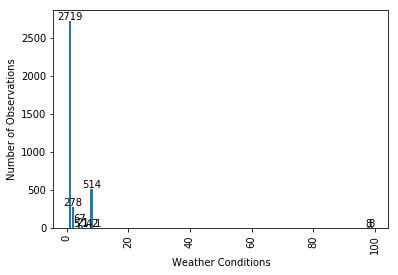

In [41]:
a = veh_df['WEATHER'].value_counts()

plt.bar(a.index, a)

for x,y in zip(a.index, a):

    label = "{:}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,1), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.xticks(rotation=90)
plt.ylabel('Number of Observations')
plt.xlabel('Weather Conditions')
plt.show()

# Join dataframes into a modeling dataframe and do additional exploratory analysis and variable creation

In [42]:
crash_df['ID'] = crash_df['CASEID'].apply(str)
veh_df['ID'] = veh_df['CASEID'].apply(str)
distract_df['ID'] = distract_df['CASEID'].apply(str)
person_df['ID'] = person_df['CASEID'].apply(str)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [49]:
df_veh = crash_df.merge(veh_df, on = ['ID'], how='outer')
df_veh_distract = df_veh.merge(distract_df, on = ['ID',  'VEHNO'], how='outer')
df = df_veh_distract.merge(person_df, on = ['ID',  'VEHNO'], how='inner')

In [56]:
df_veh.groupby(['MODELYR'])['CASEWGT'].sum() # distribution of model years

MODELYR
1950.0       572.425840
1954.0       115.287608
1978.0       663.433221
1979.0       206.708059
1983.0       259.890593
1984.0      1601.225482
1985.0        96.890018
1986.0      6924.811924
1987.0       974.894025
1988.0      3070.688860
1989.0     14120.347844
1990.0      4410.396723
1991.0     13519.763917
1992.0     29535.105029
1993.0     19488.174461
1994.0     24756.445657
1995.0     45669.727309
1996.0     51879.952491
1997.0     78210.766150
1998.0     81695.842561
1999.0    129324.143606
2000.0    130114.542898
2001.0    153099.321056
2002.0    215868.144924
2003.0    251033.278910
2004.0    217712.789126
2005.0    294867.747853
2006.0    357925.660103
2007.0    257131.883218
2008.0    254625.940511
2009.0    205346.118952
2010.0    243527.178025
2011.0    239532.738811
2012.0    262116.598023
2013.0    281061.984076
2014.0    345395.126254
2015.0    288409.723960
2016.0    298432.954107
2017.0    179074.234774
2018.0     14555.129128
9999.0     67531.990713
Name: CA

In [64]:
np.sort(df_veh[df_veh['MODELYR']<2500]['MODELYR'].unique()) # not including "9999", which indicates model year is unknown

array([1950., 1954., 1978., 1979., 1983., 1984., 1985., 1986., 1987.,
       1988., 1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996.,
       1997., 1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005.,
       2006., 2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014.,
       2015., 2016., 2017., 2018.])

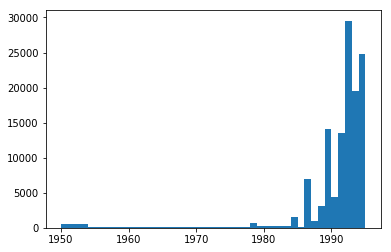

In [66]:
modyears = np.sort(df_veh[df_veh['MODELYR']<2500]['MODELYR'].unique()) 
plt.hist(df_veh[df_veh['MODELYR']<2500]['MODELYR'], weights=df_veh[df_veh['MODELYR']<2500]['CASEWGT'], bins=modyears); # histogram of model years, using weights

In [44]:
df_cols = ['CASENO', 'CRASHMONTH', 'DAYOFWEEK', 'CRASHTIME', 'MANCOLL', 'CASEWGT', 'ID',  'VEHNO', 'MODELYR', 'DAMPLANE', 'SPEEDLIMIT', 'PARALCOHOL', 'RELTOJUNCT', 'TRAFFLOW', 'LIGHTCOND',
       'WEATHER', 'DISTRACT', 'DVTOTAL', 'DVEST', 'DV', 'DISTRACTN', 'OCCNO', 'MAIS', 'SEATLOC', 'AGE', 'HEIGHT', 'WEIGHT', 'SEX', 'PARBELTUSE', 'PARAIRBAG',  'BELTUSE',
       'CHILDSEATUSE', 'TREATMENT', 'MEDFACILITY', 'HOSPSTAY', 'EMSDATA', 'BMI']
df = df[df_cols]

In [48]:
df.groupby(['BMI'])['CASEWGT'].sum() # BMI's, by person. Note that a BMI of 100 is investigater futher below.

BMI
10     7.998490e+01
11     1.398629e+04
12     9.024072e+02
13     9.193266e+03
14     1.388416e+04
15     8.575179e+03
16     5.284178e+04
17     4.675854e+04
18     8.310730e+04
19     1.132910e+05
20     1.660932e+05
21     1.074082e+05
22     2.436370e+05
23     2.264686e+05
24     2.783367e+05
25     2.472408e+05
26     2.380845e+05
27     3.009060e+05
28     2.276732e+05
29     1.414986e+05
30     1.000327e+05
31     9.478883e+04
32     1.639299e+05
33     9.912983e+04
34     6.072723e+04
35     6.539775e+04
36     4.534379e+04
37     4.555453e+04
38     3.086732e+04
39     1.185662e+04
40     3.852962e+04
41     2.132744e+04
42     2.071214e+04
43     1.965748e+04
44     9.638661e+03
45     4.861232e+03
46     1.100826e+04
47     2.145963e+03
48     1.055998e+04
49     9.883311e+03
50     6.599335e+03
51     1.003758e+03
52     2.057706e+03
53     1.153677e+01
54     5.627607e+02
55     1.849540e+03
56     1.055715e+04
57     5.087748e+02
58     4.811398e+03
59     7.333334e

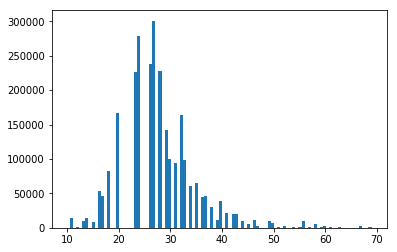

In [69]:
plt.hist(df[df['BMI']<100]['BMI'], weights=df[df['BMI']<100]['CASEWGT'], bins=100); # histogram of BMI, using weights

In [46]:
df.isnull().sum()

CASENO             0
CRASHMONTH         0
DAYOFWEEK          0
CRASHTIME          0
MANCOLL            0
CASEWGT            7
ID                 0
VEHNO              0
MODELYR            0
DAMPLANE           0
SPEEDLIMIT         0
PARALCOHOL         0
RELTOJUNCT         0
TRAFFLOW           0
LIGHTCOND          0
WEATHER            0
DISTRACT           0
DVTOTAL         1613
DVEST              0
DV                 0
DISTRACTN       3731
OCCNO              0
MAIS               0
SEATLOC            0
AGE                0
HEIGHT             0
WEIGHT             0
SEX                0
PARBELTUSE         0
PARAIRBAG          0
BELTUSE            0
CHILDSEATUSE       0
TREATMENT          0
MEDFACILITY        0
HOSPSTAY           0
EMSDATA            0
BMI                0
dtype: int64

In [47]:
df.head()

,CASENO,CRASHMONTH,DAYOFWEEK,CRASHTIME,MANCOLL,CASEWGT,ID,VEHNO,MODELYR,DAMPLANE,...,SEX,PARBELTUSE,PARAIRBAG,BELTUSE,CHILDSEATUSE,TREATMENT,MEDFACILITY,HOSPSTAY,EMSDATA,BMI
0,1,1.0,3.0,19:23,0.0,1076.863485,6150,1.0,2004.0,F,...,2,3,2,0,0,3,2,3,0,25
1,1,1.0,3.0,19:23,0.0,1076.863485,6150,1.0,2004.0,F,...,1,3,2,0,0,0,0,0,0,100
2,1,1.0,3.0,19:23,0.0,1076.863485,6150,1.0,2004.0,F,...,2,5,2,99,1,0,0,0,0,100
3,1,1.0,3.0,19:23,0.0,1076.863485,6150,1.0,2004.0,F,...,1,5,2,99,1,0,0,0,0,100
4,1,1.0,3.0,19:23,0.0,1076.863485,6150,1.0,2004.0,F,...,2,2,0,99,0,0,0,0,0,100


In [48]:
check_cols = ['CRASHMONTH', 'DAYOFWEEK',  'MANCOLL', 'MODELYR', 'DAMPLANE', 'SPEEDLIMIT', 'PARALCOHOL', 'RELTOJUNCT', 'TRAFFLOW', 'LIGHTCOND',
       'WEATHER', 'DISTRACT', 'DV', 'DISTRACTN', 'MAIS', 'SEATLOC', 'AGE',  'SEX', 'PARBELTUSE', 'PARAIRBAG', 'BELTUSE',
       'CHILDSEATUSE', 'TREATMENT', 'MEDFACILITY', 'HOSPSTAY', 'EMSDATA']
for i in check_cols:
    print(i)
    print(np.sort(df[i].unique()))

CRASHMONTH
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
DAYOFWEEK
[1. 2. 3. 4. 5. 6. 7.]
MANCOLL
[0. 1. 2. 4. 5. 6. 9.]
MODELYR
[1950. 1954. 1978. 1983. 1984. 1985. 1986. 1987. 1988. 1989. 1990. 1991.
 1992. 1993. 1994. 1995. 1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003.
 2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.
 2016. 2017. 2018.]
DAMPLANE
['9' 'B' 'F' 'L' 'N' 'R' 'T' 'U']
SPEEDLIMIT
[  0.  24.  32.  40.  48.  56.  64.  72.  80.  89.  97. 105. 113. 121.
 999.]
PARALCOHOL
[0. 1. 8. 9.]
RELTOJUNCT
[0. 1. 2. 3. 4.]
TRAFFLOW
[1. 2. 3. 4. 5.]
LIGHTCOND
[1. 2. 3. 4. 5. 9.]
WEATHER
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 98. 99.]
DISTRACT
[1. 2. 3. 9.]
DV
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
DISTRACTN
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 99. nan]
MAIS
[ 0  1  2  3  4  5  6  9 99]
SEATLOC
[11 12 13 21 22 23 31 32 33 99]
AGE
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32

In [49]:
df = df.replace(999,np.NaN)

In [50]:
df['Distracted'] = np.where(df['DISTRACT']==3,1,0) # Indicator for distraction/Inattention
df['Looked_no_see'] = np.where(df['DISTRACT']==2,1,0) # Indicator for distraction/Inattention
df['Driver'] = np.where(df['SEATLOC']==11,1,0) # Front Left Seat
df['FrontPax'] = np.where((df['SEATLOC']==12) | (df['SEATLOC']==13),1,0) # Front Passenger
df['Back_Left'] = np.where((df['SEATLOC']==21) | (df['SEATLOC']==31),1,0) # 2nd or 3rd seat left
df['Back_Middle'] = np.where((df['SEATLOC']==22) | (df['SEATLOC']==32),1,0) # 2nd or 3rd seat middle
df['Back_Right'] = np.where((df['SEATLOC']==23) | (df['SEATLOC']==33),1,0) # 2nd or 3rd seat middle

In [51]:
df.isnull().sum()

CASENO              0
CRASHMONTH          0
DAYOFWEEK           0
CRASHTIME           0
MANCOLL             0
CASEWGT             7
ID                  0
VEHNO               0
MODELYR             0
DAMPLANE            0
SPEEDLIMIT         52
PARALCOHOL          0
RELTOJUNCT          0
TRAFFLOW            0
LIGHTCOND           0
WEATHER             0
DISTRACT            0
DVTOTAL          1613
DVEST               0
DV                  0
DISTRACTN        3731
OCCNO               0
MAIS                0
SEATLOC             0
AGE                56
HEIGHT           1073
WEIGHT           1060
SEX                 0
PARBELTUSE          0
PARAIRBAG           0
BELTUSE             0
CHILDSEATUSE        0
TREATMENT           0
MEDFACILITY         0
HOSPSTAY            0
EMSDATA             0
BMI                 0
Distracted          0
Looked_no_see       0
Driver              0
FrontPax            0
Back_Left           0
Back_Middle         0
Back_Right          0
dtype: int64

In [52]:
df = df[df['AGE']<100] # drop 56 observations with occupant age = 999, which indicates missing data
df.isnull().sum()

CASENO              0
CRASHMONTH          0
DAYOFWEEK           0
CRASHTIME           0
MANCOLL             0
CASEWGT             7
ID                  0
VEHNO               0
MODELYR             0
DAMPLANE            0
SPEEDLIMIT         52
PARALCOHOL          0
RELTOJUNCT          0
TRAFFLOW            0
LIGHTCOND           0
WEATHER             0
DISTRACT            0
DVTOTAL          1584
DVEST               0
DV                  0
DISTRACTN        3677
OCCNO               0
MAIS                0
SEATLOC             0
AGE                 0
HEIGHT           1019
WEIGHT           1006
SEX                 0
PARBELTUSE          0
PARAIRBAG           0
BELTUSE             0
CHILDSEATUSE        0
TREATMENT           0
MEDFACILITY         0
HOSPSTAY            0
EMSDATA             0
BMI                 0
Distracted          0
Looked_no_see       0
Driver              0
FrontPax            0
Back_Left           0
Back_Middle         0
Back_Right          0
dtype: int64

In [53]:
df = df[(df['CASEWGT']>0) & (df['SPEEDLIMIT']>0)] # drop observationns with missing data for speed limit or missing sample weights (i.e., CASEWGT)
df.isnull().sum()

CASENO              0
CRASHMONTH          0
DAYOFWEEK           0
CRASHTIME           0
MANCOLL             0
CASEWGT             0
ID                  0
VEHNO               0
MODELYR             0
DAMPLANE            0
SPEEDLIMIT          0
PARALCOHOL          0
RELTOJUNCT          0
TRAFFLOW            0
LIGHTCOND           0
WEATHER             0
DISTRACT            0
DVTOTAL          1542
DVEST               0
DV                  0
DISTRACTN        3598
OCCNO               0
MAIS                0
SEATLOC             0
AGE                 0
HEIGHT            991
WEIGHT            978
SEX                 0
PARBELTUSE          0
PARAIRBAG           0
BELTUSE             0
CHILDSEATUSE        0
TREATMENT           0
MEDFACILITY         0
HOSPSTAY            0
EMSDATA             0
BMI                 0
Distracted          0
Looked_no_see       0
Driver              0
FrontPax            0
Back_Left           0
Back_Middle         0
Back_Right          0
dtype: int64

It is interesting to note that Height and Weight have multiple missing values, but BMI does not. Investigating further...

In [54]:
np.sort(df['BMI'].unique())

array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        63,  67,  69, 100])

In [55]:
df['BMI'].value_counts()

100    1020
24      236
26      231
27      231
25      224
22      218
28      196
23      179
29      153
20      139
21      130
30      129
32      107
31      100
33       86
18       84
19       81
34       71
35       69
17       48
36       41
37       32
39       29
38       28
40       27
16       27
41       26
42       24
15       16
43       15
14       15
46       12
44        9
13        8
45        8
48        7
49        5
11        4
50        3
54        3
12        3
57        2
58        2
60        2
51        2
61        2
63        2
56        2
69        1
52        1
67        1
47        1
53        1
55        1
59        1
10        1
Name: BMI, dtype: int64

In [56]:
pd.crosstab(np.where(df['BMI']==100,1,0),df['WEIGHT'].isnull())

WEIGHT,False,True
row_0,,
0,3076,0
1,42,978


In [57]:
pd.crosstab(np.where(df['BMI']==100,1,0),df['HEIGHT'].isnull())

HEIGHT,False,True
row_0,,
0,3076,0
1,29,991


In [58]:
HW_Missing = np.where((df['HEIGHT'].isnull()) | (df['WEIGHT'].isnull()),1,0) # Height and/or weight missing

pd.crosstab(np.where(df['BMI']==100,1,0),HW_Missing)

col_0,0,1
row_0,,
0,3076,0
1,0,1020


It appears that when height and/or weight is missing, BMI has artificially been set equal to 100. This could be problematic if BMI is used in the model due to the large number of "missing" values.

Distraction and looked-but-failed-to-see are two basic types of human errors that may contribute to collision dynamics, leading to different injury severities. <br>
Front seat location, and second or third row seat, along with left, right or middle, determines how the occupant is exposed to various types of impacts as well as how the vehicle can protect the occupant

In [59]:
df['DeltaV'] = df['DV'].map(DV_dict)
df['Airbag_Deploy'] = df['PARAIRBAG'].map(airbag_dict)
df['Male'] = np.where(df.SEX==1,1,0)
df['No_Seatbelt'] = np.where(df['PARBELTUSE']==0,1,0)
df['Poor_Weather'] = np.where((df['WEATHER']!=1) & (df['WEATHER']!=2) & (df['WEATHER']!=8) & (df['WEATHER']!=98) & (df['WEATHER']!=99),1,0) # Rain, Snow, Severe Crosswinds, Fog, etc.
df['Alcohol'] = np.where(df['PARALCOHOL']==1,1,0)
df['DV1025'] = np.where(df['DV']==2,1,0) # Delta-V 15-25 kph
df['DV2540'] = np.where(df['DV']==3,1,0) # Delta-V 25-40 kph
df['DV4055'] = np.where(df['DV']==4,1,0) # Delta-V 40-55 kph
df['DV55Pl'] = np.where(df['DV']==5,1,0) # Delta-V > 55 kph
df['DV_Minor'] = np.where(df['DV']==6,1,0) # Delta-V = Minor Damage
df['DV_Moder'] = np.where(df['DV']==7,1,0) # Delta-V = Moderate Damage
df['DV_Severe'] = np.where(df['DV']==8,1,0) # Delta-V = Severe Damage
df['Front'] = np.where(df['DAMPLANE']=='F',1,0) # Frontal Impact
df['Left'] = np.where(df['DAMPLANE']=='L',1,0) # Left-Side Impact
df['Right'] = np.where(df['DAMPLANE']=='R',1,0) # Left-Side Impact
df['Junction_related'] = np.where(df['RELTOJUNCT']==0,0,1) # if related to some kind of junction or not

In [60]:
df.to_csv('CISS_Merged_Cleaned.csv') # Save dataset to main folder for project

# Notes:

1. Height, Weight, and BMI have a large number of  missing values. When BMI should be missing, it was artificially set equal to a value of 100 (this is not noted in the data documentation)
2. A small portion of observations were dropped due to missing values (i.e., Age, Case Weights, and Speed Limit). Data for these observations is not likely missing at random. There is likely systematic differences between these observations and other observations in the dataset.
3. Many of the variables have values with too few observations for stable models, if dummy variables for all but one option were included. 